In [90]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [91]:
class Neural_network:
    def __init__(self, hidden_layers, data4size, param={}):
        self.hidden_layers = hidden_layers
        self.dimensions = []
        self.data4size = data4size
        self.param = param
        self.loss_accuracy = ([], [])
        self.loss_accuracy_test = ([], [])
        
        if self.param == {}:
            self.initialisation()
            
        self.L = len(self.param)//2
        
    def initialisation(self):
        
        print(type(self.data4size[0]))
        self.data4size[0] = self.normalised_reshape(self.data4size[0]).T
        self.data4size[1] = self.data4size[1].T
        
        np.random.seed(0)
        self.dimensions = list(self.hidden_layers)
        self.dimensions.insert(0, self.data4size[0].shape[0])
        self.dimensions.append(self.data4size[1].shape[0])
 
        for l in range(1, len(self.dimensions)):
            self.param['W' + str(l)] = np.random.randn(self.dimensions[l], self.dimensions[l - 1])
            self.param['b' + str(l)] = np.random.randn(self.dimensions[l], 1)
    
    def dropout(self, A, dropout_rate):
        # Génère un masque de Bernoulli
        mask = (np.random.rand(*A.shape) > dropout_rate) / (1.0 - dropout_rate)
        return A * mask, mask  # Retourne les activations après Dropout et le masque
    
    def forward_propagation(self, X):
        activations = {'A0' : X}
        
        for l in range(1, self.L+1):
            Z = self.param['W' + str(l)].dot(activations['A' + str(l-1)]) + self.param['b' + str(l)]
            activations['A' + str(l)] = 1 / (1 + np.exp(-Z))
            
        return activations
    
    def back_propagation(self, Y, activations):
        m = Y.shape[1]
        dZ = activations['A' + str(self.L)] - Y   
        gradients = {} 
        
        for l in reversed(range(1, self.L+1)):
            gradients['dW' + str(l)] = 1/m * np.dot(dZ, activations['A' + str(l - 1)].T)
            gradients['db' + str(l)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dZ = np.dot(self.param['W' + str(l)].T, dZ) * activations['A' + str(l-1)] * (1-activations['A' + str(l-1)])
    
        return gradients
    
    def update(self, gradients, learning_rate):
        
        for l in range(1, self.L+1):
            self.param['W' + str(l)] = self.param['W' + str(l)] - learning_rate * gradients['dW' + str(l)]
            self.param['b' + str(l)] = self.param['b' + str(l)] - learning_rate * gradients['db' + str(l)]

    def log_loss(self, Y, A):
        return 1/len(Y) * np.sum(-Y * np.log(A + 1e-15) - (1 - Y) * np.log(1 - A + 1e-15))

    def accuracy_score(self, Y, A):
        accuracy = np.count_nonzero(Y.flatten() == A.flatten()) / len(A.flatten())
        return accuracy

    def predict(self, X):
        activations = self.forward_propagation(X)
        Af = activations['A'+str(self.L)]
        return (Af >= 0.5)
    
    def display_result(self):
        plt.figure(figsize=(16, 9))
        plt.subplot(2, 1, 1)
        plt.plot(self.loss_accuracy[0], label='train loss')
        plt.plot(self.loss_accuracy_test[0], label='test loss')
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(self.loss_accuracy[1], label='train acc')
        plt.plot(self.loss_accuracy_test[1], label='test acc')
        plt.legend()
        plt.show()
    
    def normalised_reshape(self, matrix):    
        return matrix.reshape(matrix.shape[0], -1)/matrix.max()
    
    def training(self, X, Y, train_length, learning_rate, nb_display, bool_display=False):
        # normalised and reshape version of data input------------------
        X = self.normalised_reshape(X).T
        Y = Y.T
        
        # display management : -----------------------------------------
        if train_length <= nb_display: x_sample_ = 1
        else: x_sample = (train_length // nb_display)
        
        # start training : -----------------------------------------
        for i in tqdm(range(train_length)):
            activations = self.forward_propagation(X)
            gradients = self.back_propagation(Y, activations)
            self.update(gradients, learning_rate)
            
            if i % x_sample == 0 :
                y_pred = self.predict(X)
                self.loss_accuracy[0].append(self.log_loss(Y, activations['A'+str(self.L)]))
                self.loss_accuracy[1].append(self.accuracy_score(Y, y_pred))
                
        # display result : -----------------------------------------------
        if bool_display: self.display_result()
        return self.param
    
    def trainingDiff(self, X_train, Y_train, X_test, Y_test, train_length, learning_rate, nb_display, bool_display=False):
        # normalised and reshape version of data input------------------
        X_train = self.normalised_reshape(X_train).T
        Y_train = Y_train.T
        
        X_test = self.normalised_reshape(X_test).T
        Y_test = Y_test.T
        
        # display management : -----------------------------------------
        if train_length <= nb_display: x_sample = 1
        else: x_sample = (train_length // nb_display)
        
        # start training : -----------------------------------------
        for i in tqdm(range(train_length)):
            activations = self.forward_propagation(X_train)
            gradients = self.back_propagation(Y_train, activations)
            self.update(gradients, learning_rate)
            
            if i % x_sample == 0 :
                y_pred = self.predict(X_train)
                self.loss_accuracy[0].append(self.log_loss(Y_train, activations['A'+str(self.L)]))
                self.loss_accuracy[1].append(self.accuracy_score(Y_train, y_pred))
                
                activations_test = self.forward_propagation(X_test)
                y_pred_test = self.predict(X_test)
                self.loss_accuracy_test[0].append(self.log_loss(Y_test, activations_test['A'+str(self.L)]))
                self.loss_accuracy_test[1].append(self.accuracy_score(Y_test, y_pred_test))
                
        # display result : -----------------------------------------------
        if bool_display: self.display_result()
        return self.param

In [92]:
from utilities import load_data
X_train, Y_train, X_test, Y_test = load_data()

In [93]:
first_neural_network = Neural_network(
    hidden_layers = (512, 1024, 1024, 1024, 512),
    data4size = [X_train, Y_train]
)

<class 'numpy.ndarray'>


In [94]:
#first_neural_network_param = first_neural_network.training(X_train, Y_train, train_length=2048, learning_rate=0.01, nb_display=1000, bool_display=False)

100%|██████████| 2000/2000 [14:23<00:00,  2.32it/s]


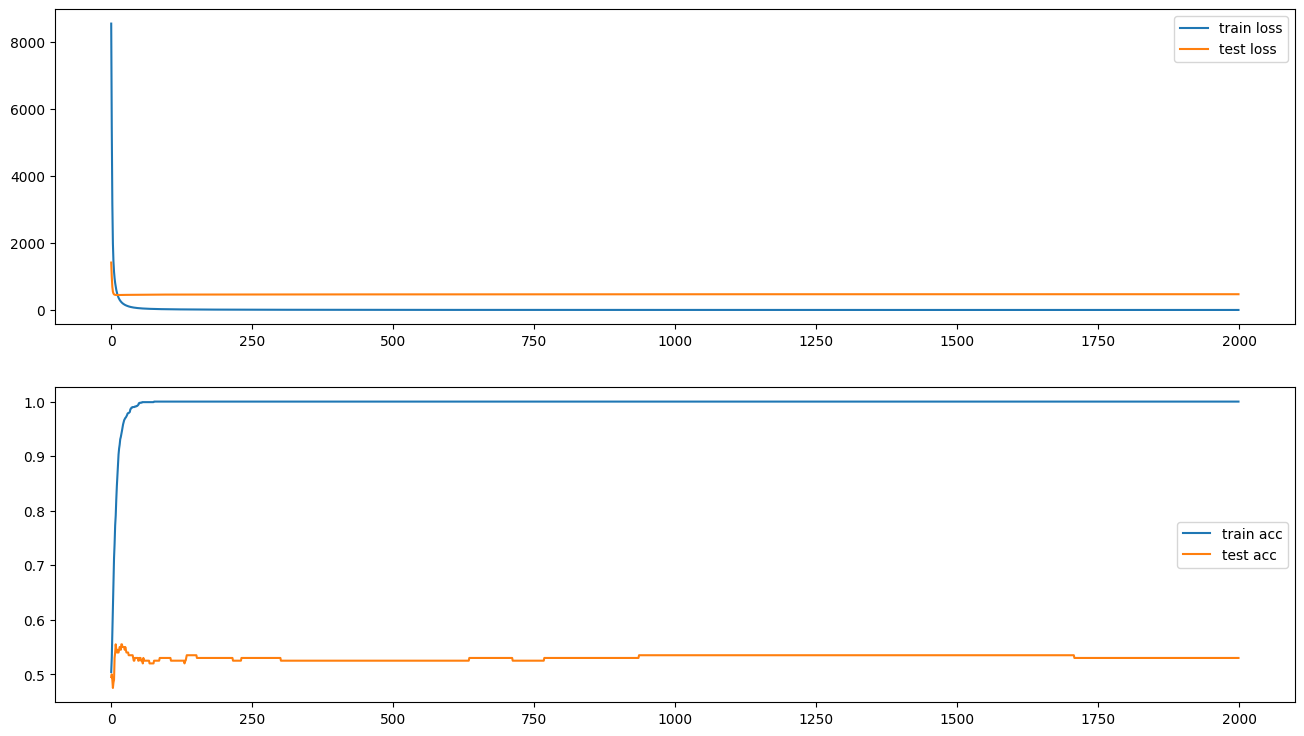

In [96]:
first_neural_network_param = first_neural_network.trainingDiff(X_train, Y_train, X_test, Y_test, train_length=2000, learning_rate=0.001, nb_display=1000, bool_display=True)